In [3]:
# Imports
import numpy as np
from scipy.optimize import minimize
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [9]:
# Helper Functions
def compute_gram(X: np.ndarray) -> np.ndarray:
    """Compute Gram matrix K_ij = x_i · x_j"""
    return X @ X.T


def solve_svm_dual(X, y, C=1.0, tol=1e-5):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    N = len(y)

    # Gram Matrix K
    K = X @ X.T
    Q = np.outer(y, y) * K

    def dual_objective(lmbda):
        # 0.5 * lambda^T Q lambda - sum(lambda)
        return 0.5 * lmbda @ (Q @ lmbda) - np.sum(lmbda)

    constraints = {'type': 'eq', 'fun': lambda lmbda_: np.dot(lmbda_, y)}
    bounds = [(0, C) for _ in range(N)]
    initial_lambda = np.zeros(N)

    solution = minimize(
        dual_objective,
        initial_lambda,
        bounds=bounds,
        constraints=constraints,
        method="SLSQP",
        options={"maxiter": 100}
    )

    lmbda = solution.x
    support = [i for i in range(N) if lmbda[i] > tol]

    w = sum(lmbda[i] * y[i] * X[i] for i in range(N))
    b_candidates = [y[i] - np.dot(w, X[i]) for i in support]
    b = float(np.mean(b_candidates))

    return lmbda, w, b, support


def decision_function(X, w, b):
    X = np.asarray(X, dtype=float)
    return X @ w + b


def predict(X, w, b):
    return np.sign(decision_function(X, w, b))


In [7]:
# Experimenting on Breast Cancer Data Set
# Load data
data = load_breast_cancer()
X = data.data
y = data.target # 0 = malignant, 1 = benign

# Map labels to {-1, +1}
y_svm = np.where(y == 0, -1, 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Using SVM solver
C = 1.0
lambda_bc, w_bc, b_bc, sv_bc = solve_svm_dual(X_train_std, y_train, C=C)

y_pred_train = predict(X_train_std, w_bc, b_bc)
y_pred_test = predict(X_test_std, w_bc, b_bc)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Custom SVM (C={C}) -> train acc: {train_acc:.3f}, test acc: {test_acc:.3f}")
print(f"# support vectors: {len(sv_bc)} out of {len(y_train)}")

# Compare with scikit-learn
sk_model = SVC(kernel="linear", C=C)
sk_model.fit(X_train_std, y_train)
sk_train_acc = sk_model.score(X_train_std, y_train)
sk_test_acc = sk_model.score(X_test_std, y_test)

print(f"sklearn SVC (C={C}) -> train acc: {sk_train_acc:.3f}, test acc: {sk_test_acc:.3f}")
print(f"# support vectors (sklearn): {np.sum(sk_model.n_support_)}")


Custom SVM (C=1.0) -> train acc: 0.991, test acc: 0.947
# support vectors: 32 out of 455
sklearn SVC (C=1.0) -> train acc: 0.991, test acc: 0.974
# support vectors (sklearn): 32


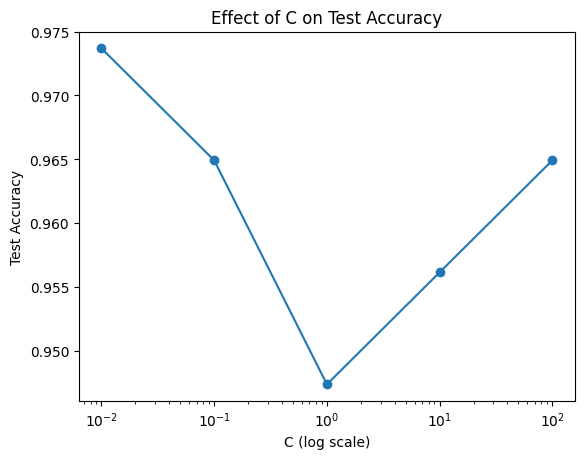

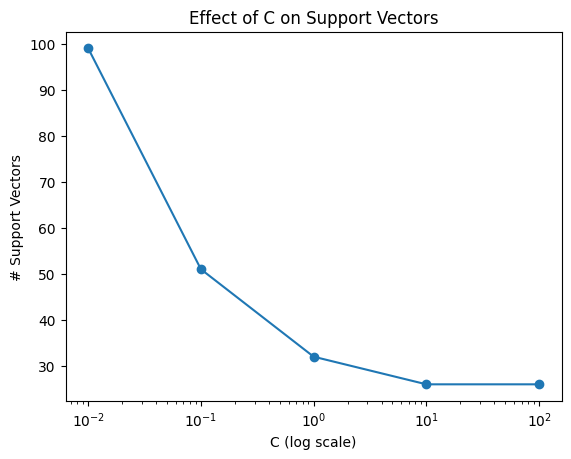

In [8]:
# Effect of reguarlization parameter C
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
metrics = []

for C in Cs:
    lambda_c, w_c, b_c, sv_c = solve_svm_dual(X_train_std, y_train, C=C)
    y_pred_test = predict(X_test_std, w_c, b_c)

    metrics.append({
        "C": C,
        "accuracy": accuracy_score(y_test, y_pred_test),
        "n_sv": len(sv_c),
        "margin": 1.0 / np.linalg.norm(w_c),
    })

# Accuracy vs C
plt.figure()
plt.plot(Cs, [m["accuracy"] for m in metrics], marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Test Accuracy")
plt.title("Effect of C on Test Accuracy")
plt.show()

# Number of support vectors vs C
plt.figure()
plt.plot(Cs, [m["n_sv"] for m in metrics], marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("# Support Vectors")
plt.title("Effect of C on Support Vectors")
plt.show()

- For small C, the model keeps a wide margin and many support vectors, with slightly higher test accuracy around C=0.01 to 0.1.

- As C increases, the model penalizes misclassification more strongly, reducing the number of support vectors and shrinking the margin.

- Our custom SVM matches scikit-learn's linear SVM in train accuracy and support-vector count, with comparable test performance.